In [11]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd

# Load the uploaded CSV file to check its structure and contents
file_path = 'result.csv'
data = pd.read_csv(file_path)


# Handle missing values by forward filling, then drop remaining NaNs
data_ffill = data.fillna(method='ffill').dropna()

# Normalize the 'Bid' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_ffill['Bid'].values.reshape(-1,1))

# Function to create dataset with look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # Based on previous timestep
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(trainX, trainY, epochs=50, batch_size=128, verbose=2)


C:\Users\Wilson\AppData\Local\Temp\ipykernel_24260\1712005298.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ffill = data.fillna(method='ffill').dropna()


Epoch 1/50
2207/2207 - 3s - loss: 0.0156 - 3s/epoch - 2ms/step
Epoch 2/50
2207/2207 - 2s - loss: 2.3525e-04 - 2s/epoch - 992us/step
Epoch 3/50
2207/2207 - 2s - loss: 1.0943e-04 - 2s/epoch - 995us/step
Epoch 4/50
2207/2207 - 2s - loss: 1.0852e-04 - 2s/epoch - 1ms/step
Epoch 5/50
2207/2207 - 2s - loss: 1.0960e-04 - 2s/epoch - 979us/step
Epoch 6/50
2207/2207 - 2s - loss: 1.0948e-04 - 2s/epoch - 987us/step
Epoch 7/50
2207/2207 - 2s - loss: 1.0950e-04 - 2s/epoch - 992us/step
Epoch 8/50
2207/2207 - 2s - loss: 1.0941e-04 - 2s/epoch - 986us/step
Epoch 9/50
2207/2207 - 2s - loss: 1.0975e-04 - 2s/epoch - 987us/step
Epoch 10/50
2207/2207 - 2s - loss: 1.0933e-04 - 2s/epoch - 983us/step
Epoch 11/50
2207/2207 - 2s - loss: 1.0955e-04 - 2s/epoch - 976us/step
Epoch 12/50
2207/2207 - 2s - loss: 1.0918e-04 - 2s/epoch - 983us/step
Epoch 13/50
2207/2207 - 2s - loss: 1.0881e-04 - 2s/epoch - 987us/step
Epoch 14/50
2207/2207 - 2s - loss: 1.0928e-04 - 2s/epoch - 991us/step
Epoch 15/50
2207/2207 - 2s - loss: 1.

In [12]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to be in the original scale of 'Bid' prices
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Inverting the scaling for the actual values, to have them in the original scale for comparison
trainY_inv = scaler.inverse_transform([trainY])
testY_inv = scaler.inverse_transform([testY])


2207/2207 [==============================] - 1s 650us/step


In [13]:
from sklearn.metrics import mean_squared_error

trainMSE = mean_squared_error(trainY, model.predict(trainX))
testMSE = mean_squared_error(testY, model.predict(testX))

trainRMSE = np.sqrt(trainMSE)
testRMSE = np.sqrt(testMSE)

print(f'Train RMSE: {trainRMSE}')
print(f'Test RMSE: {testRMSE}')


2207/2207 [==============================] - 1s 643us/step
Train RMSE: 0.01038496132894719
Test RMSE: 0.009064392311040706


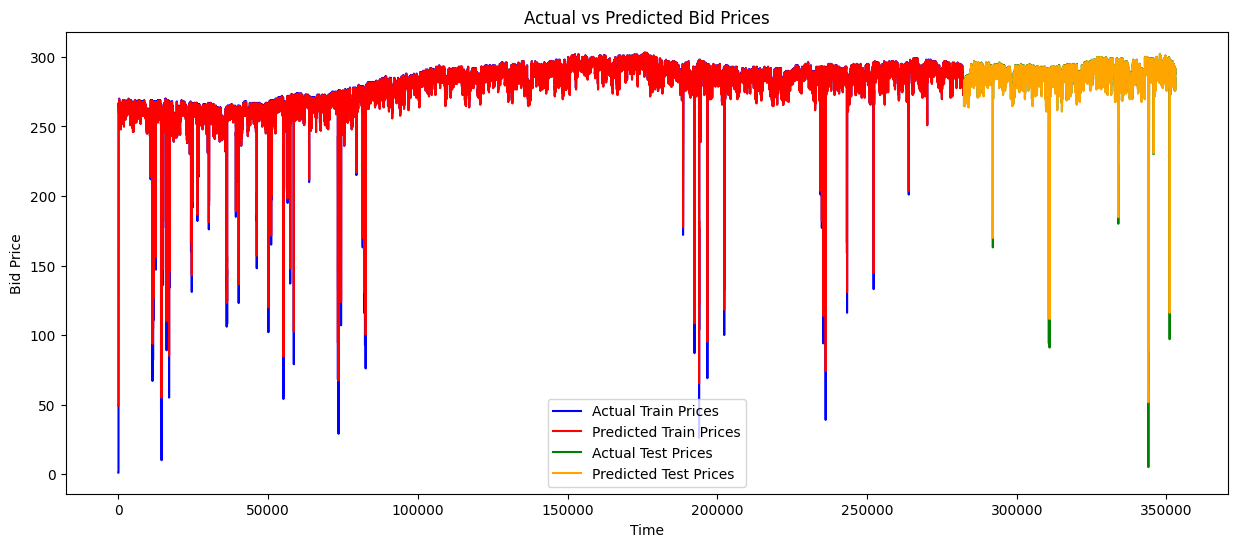

In [14]:
import matplotlib.pyplot as plt


# Generate timestamps for plotting (assuming you have a timestamp array or can generate one)
timestamps = range(len(data_ffill))

# Split the timestamps for training and test data
train_timestamps = timestamps[:len(trainPredict)]
test_timestamps = timestamps[len(trainPredict): (len(trainPredict) + len(testPredict))]

# Actual 'Bid' prices for train and test sets for plotting
actual_train = trainY_inv[0]
actual_test = testY_inv[0]

# Plotting
plt.figure(figsize=(15, 6))

# Plot training data in blue
plt.plot(train_timestamps, actual_train, 'b', label='Actual Train Prices')
plt.plot(train_timestamps, trainPredict[:,0], 'r', label='Predicted Train Prices')

# Plot test data in green
plt.plot(test_timestamps, actual_test, 'g', label='Actual Test Prices')
plt.plot(test_timestamps, testPredict[:,0], 'orange', label='Predicted Test Prices')

plt.xlabel('Time')
plt.ylabel('Bid Price')
plt.title('Actual vs Predicted Bid Prices')
plt.legend()
plt.show()


